### Empirical Example Four for RobustiPy!

#### This example is designed to show how the OLSRobust class can be used to estimate a model with longitudinal data _and_ a set of specific, constant x-variables.

Specifically, it represents an Adult Social Care (ASC) example from Zhang, Bennett and Yeandle published in the BMJ Open. You can find that paper [here](https://bmjopen.bmj.com/content/11/12/e049652). Unfortunately, because of the way that it links UKHLS data to ASC spending, we are unable to make that dataset publicly available. This notebook, however, should give you an example of how it works.

A discussion question: how close are the estimates from RobustiPy to their results for the coefficient on LA ASC Spending in Table AI, for example?

First, lets load in the libraries we might need, as always:

In [1]:
import os
from robustipy.utils import prepare_union, prepare_asc
import matplotlib.pyplot as plt
from robustipy.models import OLSRobust

Now, call the helper function in the `robustipy.utils` module (Note: this is subject to change!). We have again put data at somewhere like `./data/input/`, similar to the other examples.

In [2]:
y, c, x, g, data = prepare_asc(os.path.join('data',
                                            'input',
                                            'CleanData_LASpending.dta'))

Importantly, we want our 'grouping' variable for the longitudinal analysis to be a 'string variable':

In [3]:
data[g] = data[g].astype(str)

Lets see what we have in this dataset as a result of the `prepare_asc()` function:

In [4]:
data.columns

Index([  'wellbeing_kikert',            'lrealgs', 'dcareNew*c.lrealgs',
                 'dcareNew',                 'DR',               'lgva',
                    'Mtotp',             'ddgree',                'age',
                     2005.0,               2006.0,               2007.0,
                     2009.0,               2010.0,               2011.0,
                     2012.0,               2013.0,               2014.0,
                     2015.0,               2016.0,               2017.0,
                     2018.0,            'married',            'widowed',
                  'disable',        'lrealtinc_m',    'house_ownership',
                   'hhsize',               'work',            'retired',
                     'pidp'],
      dtype='object')

OK, so clearly a lot of variables here. Lets make sure that our time fixed effects are integers, as opposed to floats. Why do we not have a year for 2008?

In [5]:
for year in range(2005, 2019):
    if year!= 2008:
        data[float(year)] = data[float(year)].astype(int)

Lets now eyeball our data in two important ways. First, by taking the 'head' of it:

In [6]:
data.head(5)

,wellbeing_kikert,lrealgs,dcareNew*c.lrealgs,dcareNew,DR,lgva,Mtotp,ddgree,age,2005.0,...,2018.0,married,widowed,disable,lrealtinc_m,house_ownership,hhsize,work,retired,pidp
0,6.0,11.475444,0.000000,0.0,0.580409,8.547691,0.306171,0.0,53.0,0,...,0,0.0,0.0,0.0,6.947987,0.0,2,1.0,0.0,544608605
1,11.0,12.017206,0.000000,0.0,0.589392,9.062510,0.484650,1.0,58.0,0,...,0,0.0,0.0,0.0,8.124743,1.0,1,1.0,0.0,340862245
2,12.0,10.861205,0.000000,0.0,0.602811,7.963520,0.158542,0.0,56.0,0,...,0,1.0,0.0,0.0,5.979202,1.0,2,1.0,0.0,748912565
3,10.0,11.302839,11.302839,1.0,0.567938,8.274160,0.193195,1.0,71.0,0,...,0,1.0,0.0,0.0,8.367115,1.0,2,1.0,0.0,748926165
4,7.0,12.484859,0.000000,0.0,0.505666,10.017715,0.723042,1.0,26.0,0,...,0,0.0,0.0,0.0,8.006728,1.0,2,1.0,0.0,410088289


Then, by looking at the correlation matrix of it:

In [7]:
data.corr()

,wellbeing_kikert,lrealgs,dcareNew*c.lrealgs,dcareNew,DR,lgva,Mtotp,ddgree,age,2005.0,...,2018.0,married,widowed,disable,lrealtinc_m,house_ownership,hhsize,work,retired,pidp
wellbeing_kikert,1.000000,0.019236,0.058915,0.058755,-0.005181,0.002526,0.015688,-0.044843,0.003294,0.003546,...,0.003380,-0.059685,0.014160,0.221801,-0.057263,-0.090803,-0.016184,-0.109062,-0.037837,-0.002745
lrealgs,0.019236,1.000000,0.028417,0.009526,-0.090032,0.653079,0.898583,-0.000497,-0.029748,-0.004848,...,0.003819,-0.001582,0.002085,0.006956,-0.036607,-0.043963,0.043252,-0.036149,-0.013873,0.008702
dcareNew*c.lrealgs,0.058915,0.028417,1.000000,0.998937,0.031812,0.002260,0.030591,-0.050027,0.103296,-0.007538,...,0.000161,0.015376,-0.033811,0.073540,-0.025843,0.017994,0.001912,-0.058616,0.053040,0.000322
dcareNew,0.058755,0.009526,0.998937,1.000000,0.033001,-0.011206,0.012692,-0.049650,0.104201,-0.007257,...,-0.000102,0.015346,-0.033388,0.073273,-0.024590,0.018746,0.000564,-0.057492,0.053394,0.000585
DR,-0.005181,-0.090032,0.031812,0.033001,1.000000,-0.377799,0.029081,-0.103813,0.132242,-0.001054,...,-0.000540,-0.017482,0.037244,0.064991,-0.003870,0.236364,-0.089232,0.004403,0.113040,-0.028349
lgva,0.002526,0.653079,0.002260,-0.011206,-0.377799,1.000000,0.634814,0.037017,-0.066386,-0.023021,...,0.010777,0.019355,-0.015559,-0.023028,-0.018688,-0.124824,0.105742,-0.026853,-0.048453,0.068175
Mtotp,0.015688,0.898583,0.030591,0.012692,0.029081,0.634814,1.000000,-0.009123,-0.022032,-0.023610,...,0.007848,0.010179,-0.001681,0.006642,-0.037610,-0.007121,0.065105,-0.031694,-0.011488,0.046273
ddgree,-0.044843,-0.000497,-0.050027,-0.049650,-0.103813,0.037017,-0.009123,1.000000,-0.088949,-0.029921,...,0.003726,0.098297,-0.092773,-0.097433,0.238239,0.089494,-0.021607,0.235782,-0.126743,0.026187
age,0.003294,-0.029748,0.103296,0.104201,0.132242,-0.066386,-0.022032,-0.088949,1.000000,-0.008222,...,-0.000810,-0.284894,0.374536,0.353986,0.078904,0.200686,-0.409084,-0.235835,0.710650,-0.027678
2005.0,0.003546,-0.004848,-0.007538,-0.007257,-0.001054,-0.023021,-0.023610,-0.029921,-0.008222,1.000000,...,-0.002520,-0.088007,0.010553,-0.068294,-0.007396,0.029110,-0.022809,0.019604,-0.004765,-0.140620


Lets refresh a bit our memory of what y, x, c, and now g are:

In [8]:
print(y, x, c, g)

wellbeing_kikert ['lrealgs', 'dcareNew*c.lrealgs', 'dcareNew', 'DR', 'lgva', 'Mtotp', 'ddgree', 'age', 2005, 2006.0, 2007.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0] ['married', 'widowed', 'disable', 'lrealtinc_m', 'house_ownership', 'hhsize', 'work', 'retired'] pidp


That's right! They're strings and lists! Now, lets call our OLSRobust model, just like before. Note, we don't specify the important parametres for our 'fitting' yet, and that's the bit that takes the most computational time, next up. What is different about our 'x' here, to the things that we've seen before?

In [9]:
myrobust_panel = OLSRobust(y=[y], x=x, data=data.reset_index())

/home/porco/anaconda3/lib/python3.11/site-packages/robustipy/models.py:490: MissingValueWarning: Missing values found in data. Listwise deletion will be applied
  warnings.warn('Missing values found in data. Listwise deletion will be applied',


Next, actually fit the model:

In [10]:
myrobust_panel.fit(controls=c,
                   draws=10,
                   kfold=5,
                   group=g)

Output()

And then, grab our results from it:

In [11]:
asc_results = myrobust_panel.get_results()

Lets do some hopefully by now familiar things with it. First, lets have a look at the `summary_df` object, to check that everything feels right:

In [12]:
asc_results.summary_df

,median,max,min,ci_up,ci_down,ll,aic,bic,hqic,av_k_metric,spec_name,y
0,0.159652,0.177503,0.153094,0.177503,0.153094,-319209.108959,877984.217918,638675.473533,638526.415139,-0.000185,(),wellbeing_kikert
1,0.150439,0.160947,0.137899,0.160947,0.137899,-318396.504139,875833.008279,637061.906776,636906.114908,0.000030,(married),wellbeing_kikert
2,0.154624,0.159480,0.135990,0.159480,0.135990,-318402.817268,875845.634537,637074.533034,636918.741166,-0.000073,(widowed),wellbeing_kikert
3,0.154787,0.180263,0.147288,0.180263,0.147288,-318680.251519,876748.503039,637629.434995,637473.615391,0.003852,(disable),wellbeing_kikert
4,0.253485,0.258906,0.244056,0.258906,0.244056,-294928.580439,812093.160878,590124.382881,589969.979814,0.000757,(lrealtinc_m),wellbeing_kikert
...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.101800,0.112265,0.089860,0.112265,0.089860,-315583.273459,868570.546917,631505.393689,631309.125543,0.008517,"(hhsize, disable, married, house_ownership, wi...",wellbeing_kikert
252,0.194152,0.207706,0.185911,0.207706,0.185911,-292309.273279,805146.546557,584955.254908,584760.757993,0.004659,"(hhsize, married, house_ownership, widowed, re...",wellbeing_kikert
253,0.182122,0.190391,0.167855,0.190391,0.167855,-291850.012016,804076.024031,584036.712387,583842.232022,0.008042,"(hhsize, disable, married, house_ownership, re...",wellbeing_kikert
254,0.187728,0.197891,0.175464,0.197891,0.175464,-291853.094570,804082.189141,584042.877496,583848.397131,0.007900,"(hhsize, disable, house_ownership, widowed, re...",wellbeing_kikert


Then, lets plot the results from it:

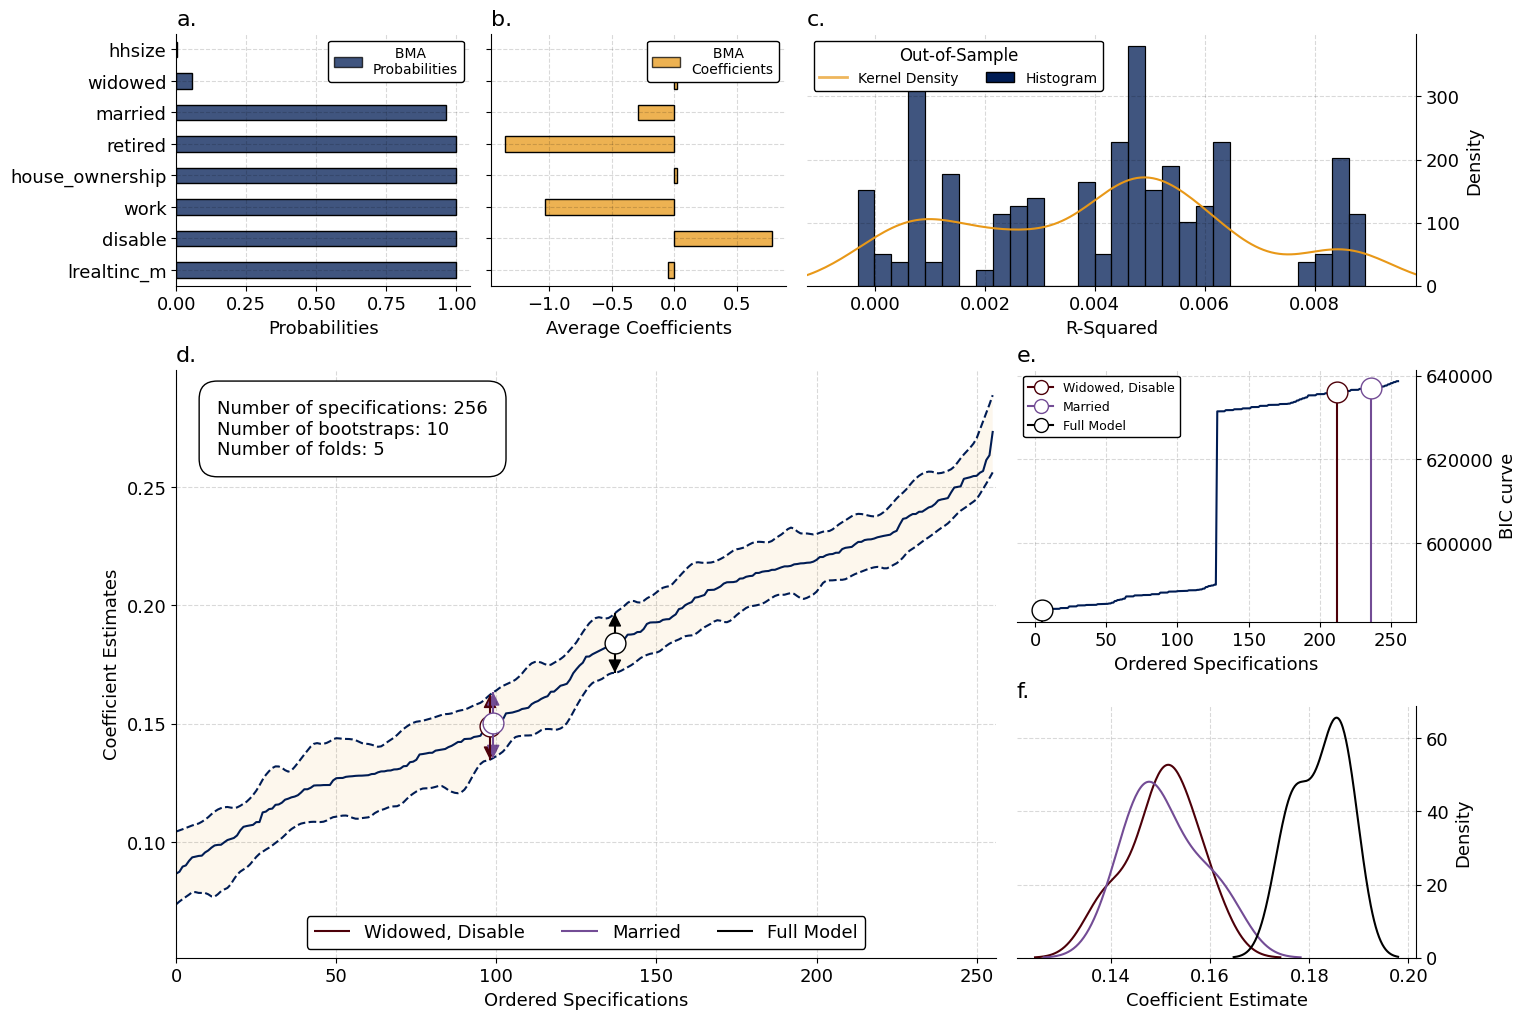

In [13]:
asc_results.plot(
    specs=[['married'],
           ['widowed', 'disable']],
    ic='bic',
    figsize=(16, 12)
)

Finally, lets print out our logging, to get even more information:

In [14]:
asc_results.summary()

1. Model Summary
Model: OLS Robust
Dependent variable: wellbeing_kikert
Independent variable: lrealgs
Number of possible controls: 8
Number of draws: 10
Number of folds: 5
Number of specifications: 256
2.Model Robustness Metrics
2.1 Inference Metrics
------------------------------------------------------------------------------------------------------------
Mean beta: 0.17
Significant portion of beta: 0.00
Positive portion of beta: 1.00
Positive and Significant portion of beta: 0.00
Min AIC: 804072.5221613615, Specs: ['hhsize', 'disable', 'married', 'house_ownership', 'widowed', 'retired', 'work', 'lrealtinc_m']
Min BIC: 584025.17478887, Specs: ['disable', 'married', 'house_ownership', 'retired', 'work', 'lrealtinc_m']
Min HQIC: 583837.4006440773, Specs: ['disable', 'married', 'house_ownership', 'retired', 'work', 'lrealtinc_m']
------------------------------------------------------------------------------------------------------------
2.2 Averaged Out-Of-Sample Metrics (r-squared)
---